To start sampling America by the county, we need to generate some data points (latitude and longitude pairs) to use. In this notebook, we generate a list of latitutes and longitudes using the Latin Square technique. We are given a latitude and longitude as the center of each county and the total square area of each county from the Gazetter Dataset downloaded from [here](http://people.bu.edu/balawson/csv/congress.csv'). I use the Latin Square technique to randomly sample the county. I use PyDOE to implement this and you can read more about Python Design Of Experiments [here](http://pythonhosted.org/pyDOE/randomized.html). I'll be using Pandas to manage data. 

In [2]:
import pandas as pd
import random
from pyDOE import *
import math
import matplotlib.pyplot as plt
%matplotlib inline

Here's the link to Wikipedia's page on [Latin Hypercube sampling](https://en.wikipedia.org/wiki/Latin_hypercube_sampling). In an oversimplified way, it can be though of as "Sudoku"- every row and column has exactly one sample. I would like to use orthogonal latin square sampling, that is to add another constraint on exactly one sample per quandrant as well, but this isn't implemented (yet) in the pyDOE library. This would be a great open source project if you are looking for one. We will be using the general latin cube sampling to randomly sample points in a county. The output of this algorithm will be values between [0-1] that we can use a ratios away from the center of the county.

In [3]:
cube = lhs(3, samples=10, criterion='center')
cube

array([[ 0.25,  0.15,  0.95],
       [ 0.05,  0.05,  0.15],
       [ 0.95,  0.55,  0.65],
       [ 0.35,  0.75,  0.55],
       [ 0.15,  0.85,  0.85],
       [ 0.55,  0.35,  0.75],
       [ 0.45,  0.65,  0.45],
       [ 0.75,  0.45,  0.05],
       [ 0.65,  0.25,  0.35],
       [ 0.85,  0.95,  0.25]])

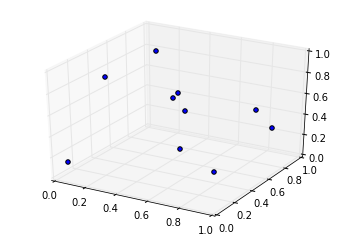

In [5]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for sample in cube:
    xs, ys, zs = sample
    ax.scatter(xs, ys, zs)
plt.show()

In [6]:
a = lhs(2, samples=30, criterion='center')
a

array([[ 0.88333333,  0.55      ],
       [ 0.21666667,  0.65      ],
       [ 0.85      ,  0.98333333],
       [ 0.58333333,  0.28333333],
       [ 0.25      ,  0.48333333],
       [ 0.95      ,  0.21666667],
       [ 0.38333333,  0.68333333],
       [ 0.61666667,  0.58333333],
       [ 0.98333333,  0.15      ],
       [ 0.28333333,  0.31666667],
       [ 0.68333333,  0.11666667],
       [ 0.48333333,  0.61666667],
       [ 0.55      ,  0.18333333],
       [ 0.01666667,  0.25      ],
       [ 0.35      ,  0.95      ],
       [ 0.75      ,  0.35      ],
       [ 0.78333333,  0.71666667],
       [ 0.65      ,  0.51666667],
       [ 0.81666667,  0.08333333],
       [ 0.41666667,  0.75      ],
       [ 0.05      ,  0.38333333],
       [ 0.31666667,  0.85      ],
       [ 0.18333333,  0.45      ],
       [ 0.11666667,  0.41666667],
       [ 0.15      ,  0.91666667],
       [ 0.08333333,  0.01666667],
       [ 0.51666667,  0.88333333],
       [ 0.91666667,  0.81666667],
       [ 0.71666667,

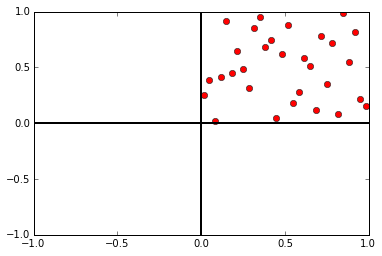

In [7]:
plt.plot(zip(*a)[0], zip(*a)[1], 'ro')
plt.plot([0, 0], [-1,1], 'k-', lw=2)
plt.plot([-1, 1], [0,0], 'k-', lw=2)
plt.show()

In [8]:
#renormalize values between -1 and 1 in order to plot on all four quadrants
b = (a-0.5)*2
b

array([[ 0.76666667,  0.1       ],
       [-0.56666667,  0.3       ],
       [ 0.7       ,  0.96666667],
       [ 0.16666667, -0.43333333],
       [-0.5       , -0.03333333],
       [ 0.9       , -0.56666667],
       [-0.23333333,  0.36666667],
       [ 0.23333333,  0.16666667],
       [ 0.96666667, -0.7       ],
       [-0.43333333, -0.36666667],
       [ 0.36666667, -0.76666667],
       [-0.03333333,  0.23333333],
       [ 0.1       , -0.63333333],
       [-0.96666667, -0.5       ],
       [-0.3       ,  0.9       ],
       [ 0.5       , -0.3       ],
       [ 0.56666667,  0.43333333],
       [ 0.3       ,  0.03333333],
       [ 0.63333333, -0.83333333],
       [-0.16666667,  0.5       ],
       [-0.9       , -0.23333333],
       [-0.36666667,  0.7       ],
       [-0.63333333, -0.1       ],
       [-0.76666667, -0.16666667],
       [-0.7       ,  0.83333333],
       [-0.83333333, -0.96666667],
       [ 0.03333333,  0.76666667],
       [ 0.83333333,  0.63333333],
       [ 0.43333333,

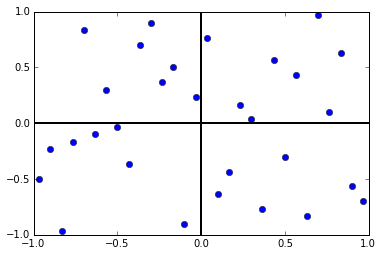

In [9]:
plt.plot(zip(*b)[0], zip(*b)[1], 'bo')
plt.plot([0, 0], [-1,1], 'k-', lw=2)
plt.plot([-1, 1], [0,0], 'k-', lw=2)
plt.show()

Now that we can sample points, we need to be able to apply these samples to each county. Using the data from the Census file we can extract the center as a pair of latitude and longitude points and the total area of the county. Assuming each county has the general shape of a square, we can derive the raduis of the county and apply our Latin Square sample to the county. 

In [10]:
#orginal data source: https://www.census.gov/geo/maps-data/data/gazetteer2014.html
df = pd.DataFrame.from_csv("csv/congress.csv")
states = df.index
df.index = df.GEOID #because current index is just state abbreviation 
df['states'] = states
#grab the first row and look at it - what info do we want to grab? ALAND, INTPTLAT, and INTPTLONG
df.iloc[0:1]

,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,states
GEOID,,,,,,,,,,
1001,1001,161526,Autauga County,1539584444,25773561,594.437,9.951,32.53216,-86.646469,AL


In [17]:
#let's try to look at the info that's interesting at the moment (1001 corresponds to the first GEOID/index value)
df["INTPTLONG"][1001]

KeyError: 'INTPTLONG'

In [18]:
#why the error message? try this one:
df["INTPTLONG                                                                                                               "][1001]

-86.646468999999996

In [19]:
#quick fix
df.columns = [x.strip() for x in df.columns]
df["INTPTLONG"][1001]

-86.646468999999996

The general idea here is to find the maxium distance from the center in the x and y direction and then find random samples within that boundary. 

In [12]:
def get_max_distances(land_area):
    #assuming counties are square (smaller area than circle - less points near or outside boundary)
    side = math.sqrt(land_area)
    r = side/2
    return r

In [13]:
def get_max_distances_circle(land_area):
    #assuming counties are circles (which they are not, but shapes are hard)
    r_2 = land_area/math.pi
    r = math.sqrt(r_2)
    return r

In [11]:
#http://gis.stackexchange.com/questions/2951/algorithm-for-offsetting-a-latitude-longitude-by-some-amount-of-meters
def meters_to_degs(x, y):
    #takes meters in the x- and y-directions
    #returns a tuple changes in degree
    #this method is refered to as 'quick and dirty' and not suggested for life-dependent applications or long distances
    return ((y/111111.0), x/(111111 * math.cos(y)))

In [14]:
def get_degree_ranges(land_area):
    d = get_max_distances(land_area)
    return (meters_to_degs(d, d))

In [16]:
#let's test the functions I wrote using the first entry in the csv
x = df.iloc[0:1].ALAND
al = get_degree_ranges(x)
al #this is a random point in the first county 

(0.17656910076302565, -0.1987309136349029)

In [20]:
def sampler(row, val):
    #row corresponds to one of the dataframe rows
    #val is the row of the Latin Square that I will use for this sample
    latin_square_coefficient = b[val]
    multiplier = get_degree_ranges(row.ALAND)
    center = [row.INTPTLAT, row.INTPTLONG]
    return latin_square_coefficient*multiplier + center

In [21]:
#constants
num_of_samples = 30 #samples per county 

latin_square_coefficient = lhs(2, samples=num_of_samples, criterion='center')
latin_square_coefficient = (latin_square_coefficient-0.5)*2

Let's test out the sampling function using the first row of the dataframe.

In [23]:
print "latitude\tlongitude"
for x in xrange(num_of_samples):
    sample = sampler(df.loc[1001], x)
    print "{0}\t{1}".format(sample[0], sample[1])

latitude	longitude
32.6675296439	-86.6663420914
32.4321041762	-86.7060882741
32.6557583705	-86.8385755498
32.5615881835	-86.5603522708
32.4438754496	-86.6398446362
32.6910721907	-86.5338548156
32.4909605432	-86.7193370017
32.5733594568	-86.6795908189
32.7028434641	-86.5073573605
32.455646723	-86.5736009983
32.5969020036	-86.4941086329
32.5262743633	-86.6928395465
32.5498169101	-86.520606088
32.3614765359	-86.5471035432
32.4791892698	-86.8253268223
32.6204445504	-86.5868497259
32.6322158238	-86.7325857292
32.5851307302	-86.6530933638
32.6439870971	-86.4808599053
32.5027318165	-86.7458344568
32.3732478093	-86.6000984535
32.4674179964	-86.7855806395
32.4203329029	-86.6265959086
32.3967903561	-86.6133471811
32.4085616295	-86.8120780947
32.3850190827	-86.4543624502
32.5380456367	-86.7988293671
32.6793009173	-86.772331912
32.608673277	-86.7590831844
32.5145030899	-86.4676111777


Sweet, so now we have 30 points generated inside our target county. We should stop and check at this point to make sure our methodology is correct, that is check to make sure these points are actually inside the correct county. We can visualize this on map. I'm grabbing the first county, which is in AL and plotting the points against the boundary of the county, using a GEOjson (which you can download [here](http://people.bu.edu/balawson/json/al.geojson) and is originally from here [here](http://catalog.opendata.city/dataset/alabama-counties-polygon/resource/af46d2c0-5f84-42ae-85a1-d2ab7d46d9a7)) 

In [24]:
import folium, json

row = df.loc[1001]
center = [row.INTPTLAT, row.INTPTLONG]
name = row.NAME

#you can download this file here: (http://catalog.civicdashboards.com/dataset/1c992edf-5ec7-456b-8191-c73a33bb79e1/resource/af46d2c0-5f84-42ae-85a1-d2ab7d46d9a7/download/ee2d088c0afb441cb8eaf57a8d279de6temp.geojson)
#it contains the boundaries for all the counties in AL
with open('al.geojson') as f:
    countylines = json.load(f)

multi = []
for x in countylines['features']:
    if name in x['properties']['name']:
        for y in x['geometry']['coordinates'][0][0]:
            multi.append([y[1], y[0]])

#sample code from the Folium tutorial at (https://github.com/python-visualization/folium) 
map_osm = folium.Map(location=[center[0], center[1]])

# Create the map and add the line
map_osm.line(multi, line_color='#FF0000', line_weight=5)

#loop over point
for x in xrange(num_of_samples):
    sample = sampler(df.loc[1001], x)
    map_osm.simple_marker([sample[0], sample[1]], popup='Sample Number: {0}'.format(x))

map_osm.create_map(path='osm.html')


In [27]:
#http://nbviewer.ipython.org/url/ocefpaf.github.com/python4oceanographers/downloads/notebooks/2015-02-02-cartopy_folium_shapefile.ipynb
#This function is created by Filipe Fernandes and found at the above link, used under CC:Attribution-ShareAlike. No modifications have been made.
from IPython.display import IFrame, HTML

def inline_map(m, width=500, height=500):
    """Takes a folium instance and embed HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed
inline_map(map_osm)

Okay let's see how we did for this one example county. Note: our sampling is based on a random algorithm so everyone *should* have different plots. 

Discussion: Do we include points that are in the county? How to they relate to the different things we are measuring?

In [19]:
#blank dataframe
samples = pd.DataFrame(columns=[x for x in range(num_of_samples)])

In [20]:
#sample
for idx, row in df.iterrows():
    for x in range(num_of_samples):
        sample =  (sampler(row, x))
        samples.loc[idx,x] = (sample[0], sample[1])

In [21]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 1001 to 56045
Data columns (total 30 columns):
0     3142 non-null object
1     3142 non-null object
2     3142 non-null object
3     3142 non-null object
4     3142 non-null object
5     3142 non-null object
6     3142 non-null object
7     3142 non-null object
8     3142 non-null object
9     3142 non-null object
10    3142 non-null object
11    3142 non-null object
12    3142 non-null object
13    3142 non-null object
14    3142 non-null object
15    3142 non-null object
16    3142 non-null object
17    3142 non-null object
18    3142 non-null object
19    3142 non-null object
20    3142 non-null object
21    3142 non-null object
22    3142 non-null object
23    3142 non-null object
24    3142 non-null object
25    3142 non-null object
26    3142 non-null object
27    3142 non-null object
28    3142 non-null object
29    3142 non-null object
dtypes: object(30)
memory usage: 761.0+ KB


In [22]:
print "latitude\tlongitude"
for x in samples.loc[1001]:
    print "{0}\t{1}".format(x[0], x[1])

latitude	longitude
32.6204445504	-86.6795908189
32.4085616295	-86.4941086329
32.608673277	-86.6928395465
32.5145030899	-86.5868497259
32.5380456367	-86.7590831844
32.455646723	-86.7855806395
32.5262743633	-86.8385755498
32.3967903561	-86.520606088
32.3614765359	-86.7193370017
32.4674179964	-86.772331912
32.5733594568	-86.7060882741
32.6557583705	-86.8253268223
32.4791892698	-86.7458344568
32.3732478093	-86.7988293671
32.6322158238	-86.5736009983
32.6910721907	-86.6530933638
32.6675296439	-86.5471035432
32.6793009173	-86.5073573605
32.5498169101	-86.5338548156
32.5615881835	-86.6265959086
32.5027318165	-86.4543624502
32.4203329029	-86.5603522708
32.4909605432	-86.6398446362
32.7028434641	-86.4808599053
32.6439870971	-86.4676111777
32.4438754496	-86.6133471811
32.5851307302	-86.8120780947
32.3850190827	-86.7325857292
32.4321041762	-86.6663420914
32.5969020036	-86.6000984535


In [23]:
#get the state abbreviation for later use
samples['states'] = df.states

In [25]:
samples.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,states
1001,"(32.6204445504, -86.6795908189)","(32.4085616295, -86.4941086329)","(32.608673277, -86.6928395465)","(32.5145030899, -86.5868497259)","(32.5380456367, -86.7590831844)","(32.455646723, -86.7855806395)","(32.5262743633, -86.8385755498)","(32.3967903561, -86.520606088)","(32.3614765359, -86.7193370017)","(32.4674179964, -86.772331912)",...,"(32.4203329029, -86.5603522708)","(32.4909605432, -86.6398446362)","(32.7028434641, -86.4808599053)","(32.6439870971, -86.4676111777)","(32.4438754496, -86.6133471811)","(32.5851307302, -86.8120780947)","(32.3850190827, -86.7325857292)","(32.4321041762, -86.6663420914)","(32.5969020036, -86.6000984535)",AL
1003,"(30.803597046, -87.8220986981)","(30.4570873356, -87.3963211886)","(30.7843465066, -87.8525113774)","(30.6303421908, -87.6092099434)","(30.6688432697, -88.0045747737)","(30.5340894934, -88.0654001322)","(30.6495927303, -88.1870508492)","(30.4378367961, -87.4571465471)","(30.3800851777, -87.9133367359)","(30.5533400329, -88.0349874529)",...,"(30.476337875, -87.5483845848)","(30.5918411119, -87.7308606604)","(30.9383508223, -87.3659085093)","(30.842098125, -87.3354958301)","(30.514838954, -87.6700353019)","(30.7458454276, -88.1262254907)","(30.4185862566, -87.9437494152)","(30.4955884145, -87.7916860189)","(30.7650959671, -87.6396226226)",AL
1005,"(31.9779672831, -85.4516193499)","(31.7194530037, -85.1911333906)","(31.9636053787, -85.4702254898)","(31.8487101434, -85.3213763703)","(31.8774339522, -85.5632561895)","(31.7769006213, -85.6004684694)","(31.8630720478, -85.6748930292)","(31.7050910993, -85.2283456705)","(31.662005386, -85.5074377697)","(31.7912625257, -85.5818623295)",...,"(31.7338149081, -85.2841640904)","(31.8199863346, -85.39580093)","(32.078500614, -85.1725272507)","(32.0066910919, -85.1539211108)","(31.7625387169, -85.3585886501)","(31.9348815698, -85.6376807493)","(31.6907291949, -85.5260439096)","(31.7481768125, -85.4330132099)","(31.9492434743, -85.3399825102)",AL
1007,"(33.1062434578, -87.1573177178)","(32.8894023591, -86.988367298)","(33.0941967301, -87.169385605)","(32.9978229084, -87.0728425079)","(33.0219163639, -87.2297250406)","(32.9375892699, -87.2538608149)","(33.0098696361, -87.3021323634)","(32.8773556314, -87.0125030722)","(32.8412154483, -87.1935213792)","(32.9496359976, -87.2417929278)",...,"(32.9014490868, -87.0487067336)","(32.973729453, -87.1211140564)","(33.1905705517, -86.9762994108)","(33.1303369132, -86.9642315237)","(32.9255425422, -87.0969782822)","(33.0701032747, -87.2779965892)","(32.8653089037, -87.2055892664)","(32.9134958145, -87.1452498307)","(33.0821500024, -87.084910395)",AL
1009,"(34.0693069184, -86.5354236619)","(33.8486295143, -86.7091151554)","(34.0570470626, -86.5230171266)","(33.9589682163, -86.6222694086)","(33.9834879279, -86.4609844504)","(33.8976689374, -86.4361713799)","(33.9712280721, -86.3865452389)","(33.8363696585, -86.6843020849)","(33.7995900911, -86.4982040561)","(33.9099287932, -86.4485779151)",...,"(33.86088937, -86.6470824791)","(33.9344485048, -86.5726432676)","(34.1551259089, -86.7215216906)","(34.09382663, -86.7339282259)","(33.8854090816, -86.5974563381)","(34.032527351, -86.4113583094)","(33.8241098027, -86.4857975209)","(33.8731492258, -86.5478301971)","(34.0447872068, -86.6098628734)",AL


In [24]:
samples.to_csv('csv/samples.csv')

Now we have the samples, we can query those locations and begin to ask questions. Below, I will show you how to work with a few corporate APIs to pursue some questions.

We can try this using the Uber and Yelp APIs [here](http://nbviewer.ipython.org/github/benlawson/intro-to-data/blob/master/sampler.ipynb?flush_cache=true)

In [1]:
# Code for setting the style of the notebook

from IPython.core.display import HTML
def css_styling():
    styles = open("./theme/custom.css", "r").read()
    return HTML(styles)
css_styling()